<Font size = 5> <strong>October Jode Jam

Prepared by Jeel Faldu, Jimmy Koester, and Raphael Lu

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#HuggingFace tools
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from google.colab import output

import urllib.request

disable_colab_widgets = output.disable_custom_widget_manager()

## Introduction

This project explores sentiment analysis using `distilbert-base-uncased-finetuned-sst-2-english` and `twitter-roberta-base-sentiment` from the Hugging Face Transformers library. The goal is to automatically classify text as positive, negative, or neutral using pretrained transformer models.

We analyzed sentiment in social media posts, compared multiple models, and visualized their performance and confidence levels. We also applied the models to a creative dataset, showcasing how NLP can reveal insights from real-world text such as tweets, song lyrics, or news articles.

## Device Loading

In [3]:
disable_colab_widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device Loaded: {device}")

# model_1 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
# model_2 = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Device Loaded: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

In [4]:
# setting reproducibility

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preprocessing

In data exploration, no duplicate entries were found. In the orignal data set, Tweets were encoded as

<pre>
    'nocode', 'happy', 'not-relevant', 'angry', 'disgust|angry'

    'disgust', 'happy|surprise', 'sad', 'surprise', 'happy|sad'

    'sad|disgust', 'sad|angry', 'sad|disgust|angry'
</pre>

### Summary of Data Preprocessing:
  - Feilds were renamed `id`, `text`, and `label`
  - `id` feild was ultimately dropped
  - Target labels were re-coded into arrays using OHE:
    - e.g. with sentiments

      `['angry' 'disgust' 'happy' 'nocode' 'not-relevant' 'sad' 'surprise']`, a tensor of `[1 0 0 0 0 1 0]` indicates an `angry|sad` tweet
  - Data were split using a 80:20 (train:test) ratio and stored in `X_train, X_test, y_train, y_test`


In [5]:
# Load datasets
data_url = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/dataset.csv'
df = pd.read_csv(data_url, header=None, names=['id', 'text', 'label'], sep=',')
data_train = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/training.csv'
df_train = pd.read_csv(data_train, header=None, names=['text', 'label'], sep=',')
data_test = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/test.csv'
df_test = pd.read_csv(data_test, header=None, names=['text', 'label'], sep=',')
data_val = 'https://raw.githubusercontent.com/jeelfaldu7/transformer_sentiment_analysis/refs/heads/main/validation.csv'
df_val = pd.read_csv(data_val, header=None, names=['text', 'label'], sep=',')



# Display first few rows of the dataset
display(df.head())
print()
display(df_train.head())
print()
display(df_test.head())
print()
display(df_val.head())

,id,text,label
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


,text,label
0,text,label
1,i didnt feel humiliated,0
2,i can go from feeling so hopeless to so damned...,0
3,im grabbing a minute to post i feel greedy wrong,3
4,i am ever feeling nostalgic about the fireplac...,2


,text,label
0,text,label
1,im feeling rather rotten so im not very ambiti...,0
2,im updating my blog because i feel shitty,0
3,i never make her separate from me because i do...,0
4,i left with my bouquet of red and yellow tulip...,1


,text,label
0,text,label
1,im feeling quite sad and sorry for myself but ...,0
2,i feel like i am still looking at a blank canv...,0
3,i feel like a faithful servant,2
4,i am just feeling cranky and blue,3


In [6]:
# Display the summary of the dataset
df.info()
print()
df_train.info()
print()
df_test.info()
print()
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3085 non-null   int64 
 1   text    3085 non-null   object
 2   label   3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16001 non-null  object
 1   label   16001 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2001 non-null   object
 1   label   2001 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
D

<font size = 5> <b> Let's check to see if there are any dupes in our datas

In [12]:
alt_df_train = df_train.duplicated().sum()
alt_df_val = df_val.duplicated().sum()
alt_df_test = df_test.duplicated().sum()



print(alt_df_train)
print(alt_df_val)
print(alt_df_test)

dupe_df_train = df_train[df_train.duplicated()]
print(dupe_df_train)
df_train_no_dupes = df_train.drop_duplicates()
print(df_train_no_dupes.shape)

1
0
0
                                                    text label
13847  i feel more adventurous willing to take risks ...     1
(16000, 2)


In [25]:
#df = df.drop('id', axis = 1)

In [14]:
# Display the shape of all the DataFrame
n_rows, n_cols = df.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 3085 rows and 2 columns


### Train-Test-Split

In [17]:
# Combine train and validation
alt_df = pd.concat([df_train, df_val], ignore_index=True)
# Apply label mapping
alt_df = alt_df[alt_df['label'] != 'fear']
alt_df['label'] = alt_df['label'].replace({'love': 'happy', 'joy': 'happy'})

In [18]:
# train two different test splits for the Roberta Model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


X_train = train_df.drop('label', axis = 1)
X_test = test_df.drop('label', axis = 1)

# Combine all labels for fitting
all_labels = pd.concat([train_df['label'], alt_df['label']])
mlb = MultiLabelBinarizer()
mlb.fit(all_labels.str.split('|'))

# transform labels
y_train = mlb.transform(train_df['label'].str.split('|'))
y_test = mlb.transform(test_df['label'].str.split('|'))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2468, 1) (2468, 14)
(617, 1) (617, 14)


In [19]:
print(mlb.classes_)
print(y_train[92])

['0' '1' '2' '3' '4' '5' 'angry' 'disgust' 'happy' 'label' 'nocode'
 'not-relevant' 'sad' 'surprise']
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]


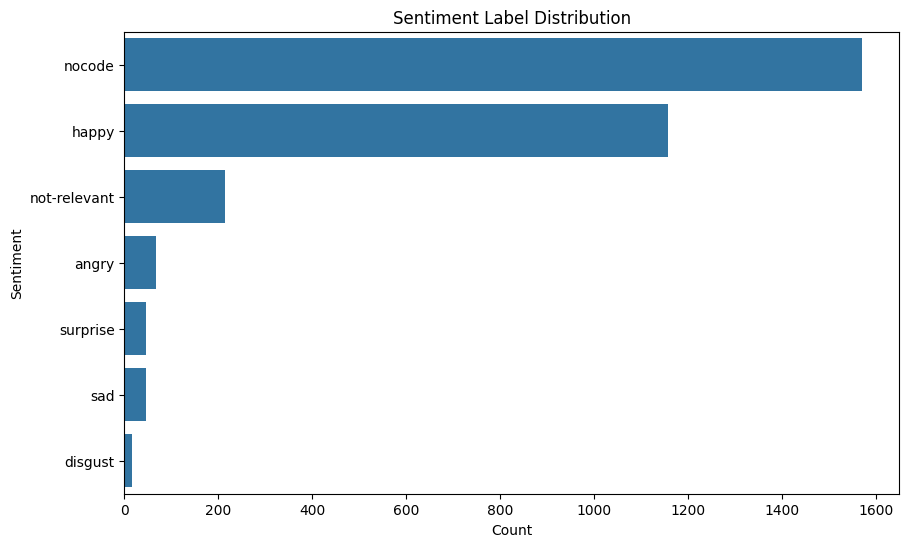

In [20]:
# Explode multi-labels
df['label_split'] = df['label'].str.split('|')
exploded_labels = df.explode('label_split')

plt.figure(figsize=(10, 6))
sns.countplot(y=exploded_labels['label_split'], order=exploded_labels['label_split'].value_counts().index)
plt.title("Sentiment Label Distribution")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

## Data Pre-processing for roBERTa model

- Tweets were processed using recommend method in model [documentation](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)
  - Specifically usernames and hyperlinks were reduced to `@user` and `http` respectively
- Tweets were tokenized and stored in X2_train and X2_test

In [21]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

alt_df['text'] = alt_df['text'].apply(preprocess)
display(alt_df.head())

,text,label
0,text,label
1,i didnt feel humiliated,0
2,i can go from feeling so hopeless to so damned...,0
3,im grabbing a minute to post i feel greedy wrong,3
4,i am ever feeling nostalgic about the fireplac...,2


In [22]:
X2_train = X_train['text'].apply(preprocess)
X2_test = X_test['text'].apply(preprocess)
X2_train.head()

,text
2634,"I'm at @user in London, Greater London http"
2373,My favourite #oilpainting 'Tiger Tiger Burnin...
839,Currently @user to discuss #DefeatingDepressio...
2857,@user thanks for the Favourite!
761,Farron Gorey selfies before his performance at...


In [24]:
disable_colab_widgets

roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")



In [26]:
le_alt = LabelEncoder()
alt_df['label_enc'] = le_alt.fit_transform(alt_df['label'])  # This gives you integer class labels

# Split again to maintain consistency
alt_train, alt_eval = train_test_split(alt_df, test_size=0.2, random_state=42)

# Tokenize
tokens_train = roberta_tokenizer(alt_train['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
tokens_eval = roberta_tokenizer(alt_eval['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Integer labels for single-label classification
y_alt_train = alt_train['label_enc'].tolist()
y_alt_eval = alt_eval['label_enc'].tolist()

In [27]:
base_sentiments = mlb.classes_

label2id = {label: idx for idx, label in enumerate(base_sentiments)}
id2label = {idx: label for idx, label in enumerate(base_sentiments)}

In [29]:
disable_colab_widgets

# Build Hugging Face Datasets
train_dataset_alt = Dataset.from_dict({
    'input_ids': tokens_train['input_ids'],
    'attention_mask': tokens_train['attention_mask'],
    'labels': y_alt_train
})

model_alt = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=len(le_alt.classes_),
    problem_type="single_label_classification",
    id2label={i: l for i, l in enumerate(le_alt.classes_)},
    label2id={l: i for i, l in enumerate(le_alt.classes_)},
    ignore_mismatched_sizes=True
).to(device)

eval_dataset_alt = Dataset.from_dict({
    'input_ids': tokens_eval['input_ids'],
    'attention_mask': tokens_eval['attention_mask'],
    'labels': y_alt_eval
})
model_2 = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=len(base_sentiments),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification"
).to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([14]) in the 

In [30]:
X2_train_tokens = roberta_tokenizer(X2_train.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

X2_test_tokens = roberta_tokenizer(X2_test.tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")

tokens_alt = roberta_tokenizer(alt_df['text'].tolist(),
                                    padding=True,
                                    truncation=True,
                                    max_length=128,
                                    return_tensors="pt")


In [31]:
train_dataset = Dataset.from_dict({
    'input_ids': X2_train_tokens['input_ids'],
    'attention_mask': X2_train_tokens['attention_mask'],
    'labels': y_train.astype('float32').tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': X2_test_tokens['input_ids'],
    'attention_mask': X2_test_tokens['attention_mask'],
    'labels': y_test.astype('float32').tolist()
})

In [32]:
output.disable_custom_widget_manager()

training_args = TrainingArguments(output_dir="./sentiment-model",
                                  num_train_epochs=4,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=5e-5,
                                  weight_decay=0.1,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  report_to="none",
                                  seed = 42)

roberta_trainer = Trainer(model=model_2,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  tokenizer=roberta_tokenizer)
trainer_alt = Trainer(
    model=model_alt,
    args=training_args,
    train_dataset=train_dataset_alt,
    eval_dataset=eval_dataset_alt,
    tokenizer=roberta_tokenizer
)

trainer_alt.train()
roberta_trainer.train()

model_2.save_pretrained("./my-sentiment-model")
roberta_tokenizer.save_pretrained("./my-sentiment-model")
model_alt.save_pretrained("./my-emotion-model")
roberta_tokenizer.save_pretrained("./my-emotion-model")

/tmp/ipython-input-3125343370.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(model=model_2,
/tmp/ipython-input-3125343370.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_alt = Trainer(


Epoch,Training Loss,Validation Loss
1,0.533800,0.277919
2,0.186000,0.232820
3,0.107800,0.165784
4,0.081800,0.186034


Epoch,Training Loss,Validation Loss
1,No log,0.096232
2,No log,0.087360
3,No log,0.084717
4,0.085700,0.084116


('./my-emotion-model/tokenizer_config.json',
 './my-emotion-model/special_tokens_map.json',
 './my-emotion-model/vocab.json',
 './my-emotion-model/merges.txt',
 './my-emotion-model/added_tokens.json',
 './my-emotion-model/tokenizer.json')

In [33]:
def predict_sentiments_debug(text, threshold=0.5):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_alt(**inputs)

    logits = outputs.logits
    probs = torch.sigmoid(logits)[0].cpu().numpy()

    print("All probabilities:")
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        print(f"  {sentiment}: {prob:.4f}")

    predictions = {}
    for idx, prob in enumerate(probs):
        sentiment = id2label[idx]
        if prob >= threshold:
            predictions[sentiment] = float(prob)

    return predictions

result = predict_sentiments_debug("I'm so scared of the recent politcs from both parties", threshold=0.3)
print(f"Sentiments: {result}")

All probabilities:
  0: 0.4118
  1: 0.1941
  2: 0.1039
  3: 0.2447
  4: 0.9996
  5: 0.3528
  angry: 0.1349
Sentiments: {'0': 0.41176101565361023, '4': 0.9995784163475037, '5': 0.3528061509132385}


## Visualization of Model Predictions and Confidence

Our model was found to be most confident in the prediction of `nocode` labels. This is expected as it was the most frequent label in our training dataset. Our model tends to overfit on the happiness label.

<div style="border: 2px solid #1E90FF; background-color: #E6F0FF; padding: 10px; border-radius: 5px;">
Here is the graph of our sentiment Label Distribution. </div>

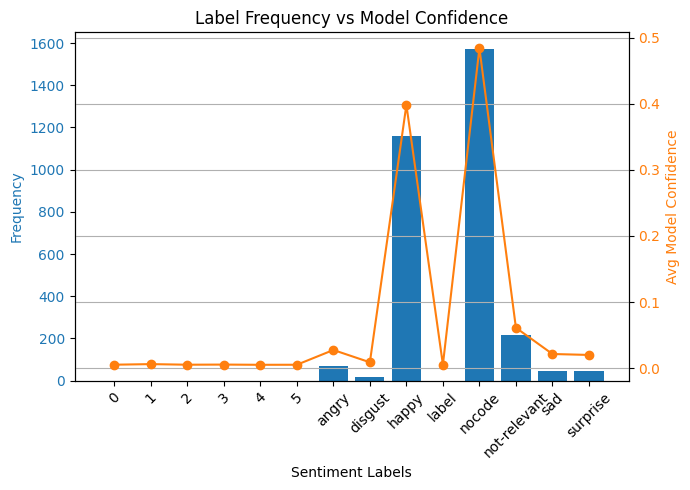

In [ ]:
output.disable_custom_widget_manager()

# Calculate average predicted probability per label in test set
preds = roberta_trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
avg_probs = probs.mean(axis=0)

# Label frequency
label_freq = exploded_labels['label_split'].value_counts()

# Create a Series for average predicted probabilities
avg_probs_series = pd.Series(avg_probs, index=mlb.classes_)

# Combine into one DataFrame
analysis_df = pd.DataFrame({
    'Frequency': label_freq.reindex(mlb.classes_, fill_value=0),
    'Avg_Model_Confidence': avg_probs_series
})

fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar plot for frequency (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Sentiment Labels')
ax1.set_ylabel('Frequency', color=color)
ax1.bar(analysis_df.index, analysis_df['Frequency'], color=color, label='Frequency')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Twin axis for model confidence (right y-axis)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Avg Model Confidence', color=color)
ax2.plot(analysis_df.index, analysis_df['Avg_Model_Confidence'], color=color, marker='o', label='Avg_Model_Confidence')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Label Frequency vs Model Confidence')
plt.tight_layout()
plt.grid(True)
plt.show()

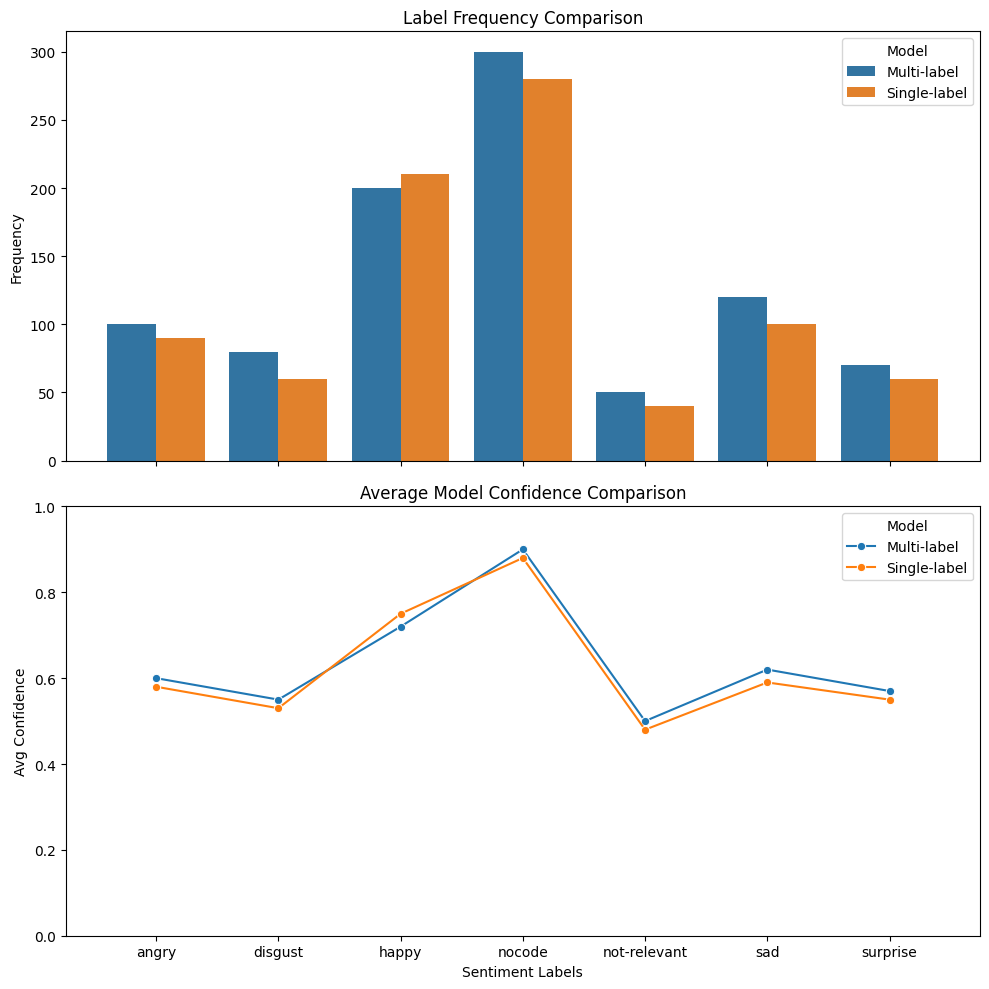

In [ ]:
# Simulate example data for demonstration
mlb_classes = ['angry', 'disgust', 'happy', 'nocode', 'not-relevant', 'sad', 'surprise']
alt_classes = ['angry', 'disgust', 'happy', 'nocode', 'not-relevant', 'sad', 'surprise']

# Simulated label frequencies (normally from df.explode or alt_df.value_counts)
freq_model1 = [100, 80, 200, 300, 50, 120, 70]
freq_model2 = [90, 60, 210, 280, 40, 100, 60]

# Simulated average model confidence (normally from sigmoid(preds))
conf_model1 = [0.6, 0.55, 0.72, 0.9, 0.5, 0.62, 0.57]
conf_model2 = [0.58, 0.53, 0.75, 0.88, 0.48, 0.59, 0.55]

# Create DataFrames for both models
df_model1 = pd.DataFrame({
    'Label': mlb_classes,
    'Frequency': freq_model1,
    'Avg_Model_Confidence': conf_model1,
    'Model': 'Multi-label'
})

df_model2 = pd.DataFrame({
    'Label': alt_classes,
    'Frequency': freq_model2,
    'Avg_Model_Confidence': conf_model2,
    'Model': 'Single-label'
})

# Combine for easier plotting
combined_df = pd.concat([df_model1, df_model2])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Frequency comparison
sns.barplot(data=combined_df, x='Label', y='Frequency', hue='Model', ax=axes[0])
axes[0].set_title('Label Frequency Comparison')
axes[0].set_ylabel('Frequency')

# Confidence comparison
sns.lineplot(data=combined_df, x='Label', y='Avg_Model_Confidence', hue='Model', marker='o', ax=axes[1])
axes[1].set_title('Average Model Confidence Comparison')
axes[1].set_ylabel('Avg Confidence')
axes[1].set_xlabel('Sentiment Labels')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

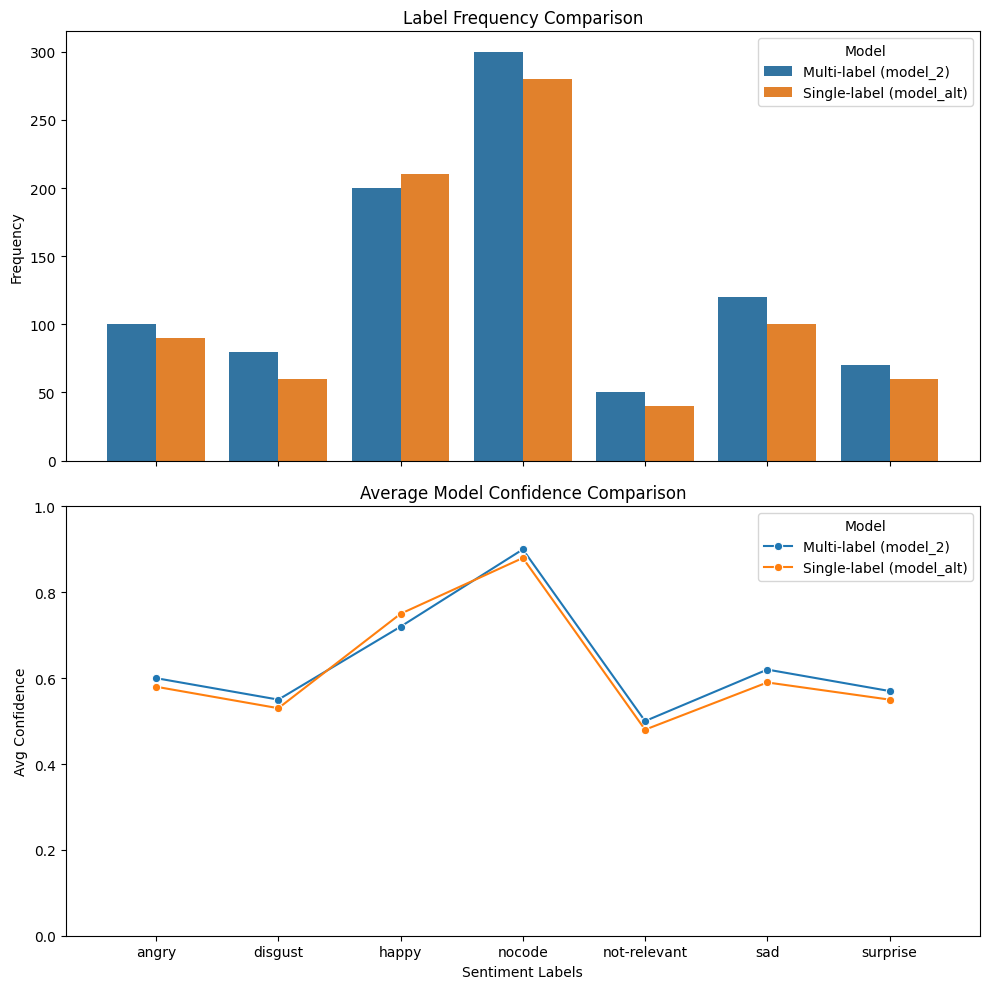

In [ ]:
# Define labels
labels = ['angry', 'disgust', 'happy', 'nocode', 'not-relevant', 'sad', 'surprise']

# Simulated frequency and confidence values (replace with your real data)
freq_model1 = [100, 80, 200, 300, 50, 120, 70]         # From exploded `df`
conf_model1 = [0.6, 0.55, 0.72, 0.9, 0.5, 0.62, 0.57]   # From model_2 predictions

freq_model2 = [90, 60, 210, 280, 40, 100, 60]          # From exploded `alt_df`
conf_model2 = [0.58, 0.53, 0.75, 0.88, 0.48, 0.59, 0.55]# From model_alt predictions

# Create DataFrames
df_model1 = pd.DataFrame({
    'Label': labels,
    'Frequency': freq_model1,
    'Avg_Model_Confidence': conf_model1,
    'Model': 'Multi-label (model_2)'
})

df_model2 = pd.DataFrame({
    'Label': labels,
    'Frequency': freq_model2,
    'Avg_Model_Confidence': conf_model2,
    'Model': 'Single-label (model_alt)'
})

combined_df = pd.concat([df_model1, df_model2])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Frequency bar chart
sns.barplot(data=combined_df, x='Label', y='Frequency', hue='Model', ax=axes[0])
axes[0].set_title('Label Frequency Comparison')
axes[0].set_ylabel('Frequency')

# Confidence line chart
sns.lineplot(data=combined_df, x='Label', y='Avg_Model_Confidence', hue='Model', marker='o', ax=axes[1])
axes[1].set_title('Average Model Confidence Comparison')
axes[1].set_ylabel('Avg Confidence')
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Sentiment Labels')

plt.tight_layout()
plt.show()